Context:

The attached file contains:

users' activations/cancellations

users' survey answers (answers are per user, not per activation/cancellation)

ruid column whose meanings do not matter


Directions:

In a Jupyter notebook (.ipynb file):

develop a model that predicts whether a user will stay or cancel

show which columns affect the result most

explain why you chose your algorithm and its configuration, what the alternatives were, how you evaluate the predictions, how you find the most influential columns.


In a Python script (.py file):
wrap your finalized model in a Python class with public methods for train, predict, and evaluate.

Helpful Tips & Tricks:


We prefer that you use python 3, pandas, scikit-learn or related technologies but if you are more fluent in any other technology, please, use that technology. We are not looking for the best code but for the best model and ability to explain your choices.

This exercise shouldn't take more than a few hours, but feel free to take more time if that is helpful to you. 

We know life gets busy. While we hope for a 3 day turnaround, please let us know if you’ll require extra time so we can plan accordingly.



todo: 
check for missing data

since survey answers are per user, we can just take the latest event as the sole row for each user

for survey questions, we can either treat the responses 1-10 as a continuous variable or treat it as categorical and create dummy variables. using dummy variables uses up degrees of freedom.

logistic regression
decision tree
random forest

In [4]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier


In [5]:
users = pd.read_csv("ds_test.csv")

In [6]:
users.drop(['Unnamed: 0', 'survey_followup', 'ruid'], axis=1, inplace=True)

In [7]:
# I'm comfortable with dropping the NAs at this point because we only go from 16162 to 15494
print(len(users))
users.dropna(inplace=True)
print(len(users))

16162
15494


In [8]:
users.head()

,userid,event_timestamp,event_label,survey_timestamp,survey_question_1,survey_question_2,survey_question_3,survey_question_4
0,358002,1432329796,activation,1432084088,10.0,b,10.0,7
1,358002,1539877368,cancellation,1432084088,10.0,b,10.0,7
2,358002,1539879413,activation,1432084088,10.0,b,10.0,7
3,358002,1539956715,cancellation,1432084088,10.0,b,10.0,7
4,358002,1551462940,activation,1432084088,10.0,b,10.0,7


In [9]:
users.event_label = users.event_label.map({'activation':1, 'cancellation':0})

In [10]:
users.event_timestamp = pd.to_datetime(users['event_timestamp'],unit='s')
users.survey_timestamp = pd.to_datetime(users['survey_timestamp'],unit='s')

In [11]:
users['month_year'] = users['event_timestamp'].dt.to_period('M')
users['survey_month_year'] = users['survey_timestamp'].dt.to_period('M')

In [12]:
users = users.sort_values('event_timestamp').drop_duplicates('userid', keep='last')

In [13]:
len(users)

6427

### Inactive users never respond with a 2, 5, or 9 to survey question 4. This is very odd behavior and makes me wary of creating dummy variables of question 4 because of how systematic those values are missing. This could be caused by a glitch in the survey where it doesn't allow inputting a 2, 5, or 9 if you are a deactivated user. Because of this, I want to treat question 4 as a continuous variable and not use dummy variables.

In [14]:
q1 = pd.get_dummies(users.survey_question_1, prefix="survey_question_1")
users = users.join(q1)

q2 = pd.get_dummies(users.survey_question_2, prefix="survey_question_2")
users = users.join(q2)

q3 = pd.get_dummies(users.survey_question_3, prefix="survey_question_3")
users = users.join(q3)

#q4 = pd.get_dummies(users.survey_question_4, prefix="survey_question_4")
#users = users.join(q4)

In [15]:
active = users[users['event_label']==1]
inactive = users[users['event_label']==0]

In [16]:
active.head()

,userid,event_timestamp,event_label,survey_timestamp,survey_question_1,survey_question_2,survey_question_3,survey_question_4,month_year,survey_month_year,...,survey_question_3_1.0,survey_question_3_2.0,survey_question_3_3.0,survey_question_3_4.0,survey_question_3_5.0,survey_question_3_6.0,survey_question_3_7.0,survey_question_3_8.0,survey_question_3_9.0,survey_question_3_10.0
12303,2029,2010-07-26 14:44:37,1,2015-07-08 05:21:41,10.0,a,10.0,3,2010-07,2015-07,...,0,0,0,0,0,0,0,0,0,1
3392,2045,2010-07-26 21:18:16,1,2015-05-31 09:05:41,3.0,c,8.0,5,2010-07,2015-05,...,0,0,0,0,0,0,0,1,0,0
15788,1932,2010-08-27 14:15:16,1,2015-07-25 08:06:32,10.0,a,10.0,10,2010-08,2015-07,...,0,0,0,0,0,0,0,0,0,1
8233,37786,2012-09-11 18:46:11,1,2015-06-21 06:07:38,10.0,a,10.0,10,2012-09,2015-06,...,0,0,0,0,0,0,0,0,0,1
2180,37596,2012-09-12 14:22:45,1,2015-05-24 07:06:42,10.0,a,10.0,6,2012-09,2015-05,...,0,0,0,0,0,0,0,0,0,1


In [17]:
inactive.head()

,userid,event_timestamp,event_label,survey_timestamp,survey_question_1,survey_question_2,survey_question_3,survey_question_4,month_year,survey_month_year,...,survey_question_3_1.0,survey_question_3_2.0,survey_question_3_3.0,survey_question_3_4.0,survey_question_3_5.0,survey_question_3_6.0,survey_question_3_7.0,survey_question_3_8.0,survey_question_3_9.0,survey_question_3_10.0
2050,1536,2010-06-01 13:01:22,0,2015-05-29 04:10:43,10.0,a,10.0,8,2010-06,2015-05,...,0,0,0,0,0,0,0,0,0,1
4346,17001,2013-05-16 13:34:24,0,2015-06-06 01:28:58,9.0,a,10.0,10,2013-05,2015-06,...,0,0,0,0,0,0,0,0,0,1
9999,89397,2013-12-29 21:46:28,0,2015-06-27 07:10:09,10.0,a,10.0,8,2013-12,2015-06,...,0,0,0,0,0,0,0,0,0,1
13692,68468,2014-01-27 15:09:12,0,2015-07-14 02:16:58,10.0,a,10.0,8,2014-01,2015-07,...,0,0,0,0,0,0,0,0,0,1
6733,135470,2014-02-05 14:22:45,0,2015-06-14 04:12:46,10.0,a,10.0,10,2014-02,2015-06,...,0,0,0,0,0,0,0,0,0,1


In [18]:
users['event_label'].value_counts()

1    4268
0    2159
Name: event_label, dtype: int64

In [19]:
active['survey_question_4'].value_counts().sort_index()

1     403
2     454
3     432
4     425
5     417
6     405
7     405
8     433
9     474
10    420
Name: survey_question_4, dtype: int64

In [20]:
inactive['survey_question_4'].value_counts().sort_index()

1     226
3     187
4     251
6     194
7     197
8     205
10    899
Name: survey_question_4, dtype: int64

<AxesSubplot:>

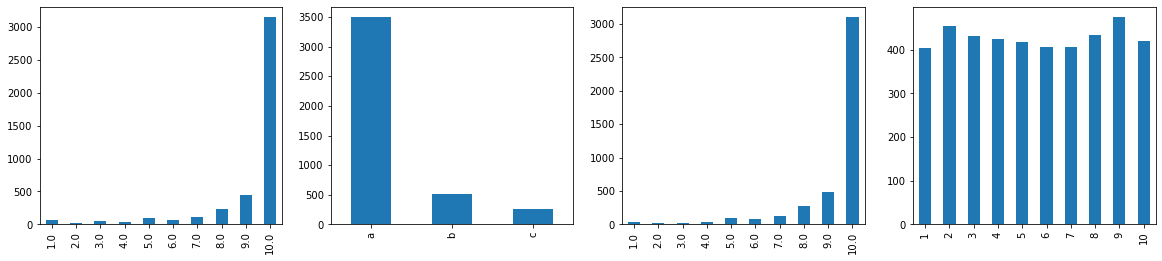

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=False)
active['survey_question_1'].value_counts().sort_index().plot(ax=axs[0],kind='bar')
active['survey_question_2'].value_counts().sort_index().plot(ax=axs[1],kind='bar')
active['survey_question_3'].value_counts().sort_index().plot(ax=axs[2],kind='bar')
active['survey_question_4'].value_counts().sort_index().plot(ax=axs[3],kind='bar')


<AxesSubplot:>

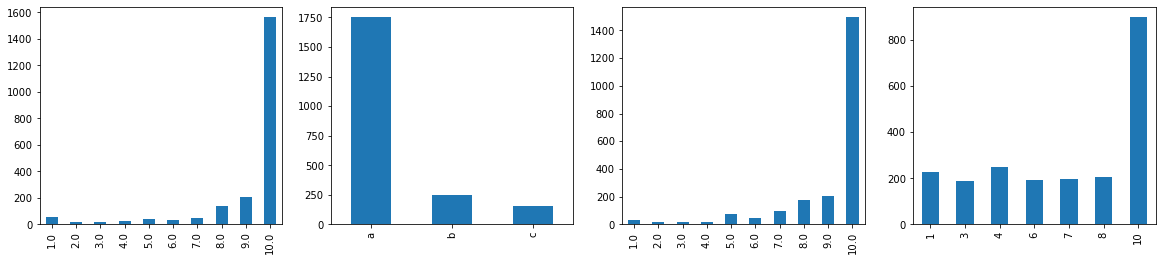

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=False)
inactive['survey_question_1'].value_counts().sort_index().plot(ax=axs[0],kind='bar')
inactive['survey_question_2'].value_counts().sort_index().plot(ax=axs[1],kind='bar')
inactive['survey_question_3'].value_counts().sort_index().plot(ax=axs[2],kind='bar')
inactive['survey_question_4'].value_counts().sort_index().plot(ax=axs[3],kind='bar')


<AxesSubplot:>

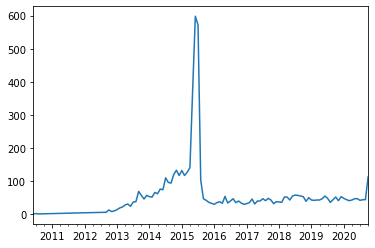

In [23]:
s = users['month_year'].value_counts().sort_index()
s.plot()

In [24]:
s.idxmax()

Period('2015-06', 'M')

C:\Users\jeffr\AppData\Local\Temp\ipykernel_41100\1491552270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active['month_year'] = active['event_timestamp'].dt.to_period('M')


<AxesSubplot:>

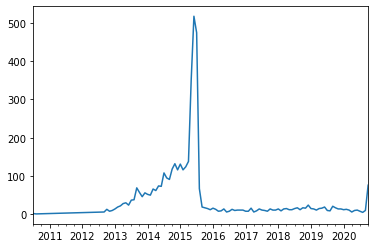

In [25]:
active['month_year'] = active['event_timestamp'].dt.to_period('M')
a = active['month_year'].value_counts().sort_index()
a.plot()

C:\Users\jeffr\AppData\Local\Temp\ipykernel_41100\922915170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive['month_year'] = inactive['event_timestamp'].dt.to_period('M')


<AxesSubplot:>

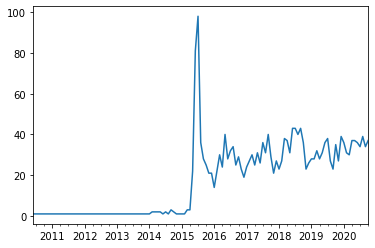

In [26]:
inactive['month_year'] = inactive['event_timestamp'].dt.to_period('M')
i = inactive['month_year'].value_counts().sort_index()
i.plot()

### There is a clear divide between the active and inactive users at July 2015 where there are more active users before that date and more inactive users after that date. So I created a new predictor called before7_15 where it is marked as 1 if the event_timestamp is before July 2015 and 0 otherwise. 

In [27]:
target_date = pd.to_datetime(datetime.date(2015, 7, 1))
users['before7_15'] = users['event_timestamp'] < target_date
users['before7_15'] = users['before7_15'].map({True:1, False:0})

In [28]:
print(s.idxmax(),a.idxmax())

2015-06 2015-06


### Taking a look at survey_timestamp, there is no discernable difference between active and inactive users so I don't do anything with it. 

<AxesSubplot:>

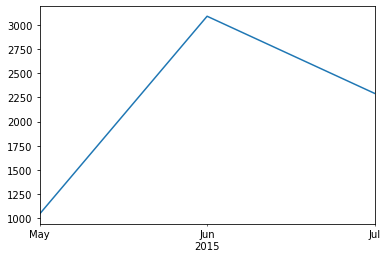

In [29]:
d = users['survey_month_year'].value_counts().sort_index()
d.plot()

<AxesSubplot:>

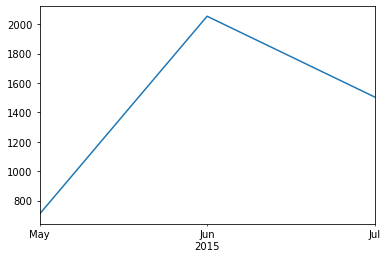

In [30]:
d = active['survey_month_year'].value_counts().sort_index()
d.plot()

<AxesSubplot:>

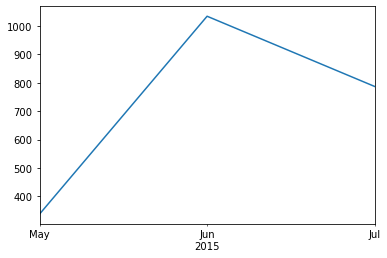

In [31]:
d = inactive['survey_month_year'].value_counts().sort_index()
d.plot()

In [32]:
users.columns

Index(['userid', 'event_timestamp', 'event_label', 'survey_timestamp',
       'survey_question_1', 'survey_question_2', 'survey_question_3',
       'survey_question_4', 'month_year', 'survey_month_year',
       'survey_question_1_1.0', 'survey_question_1_2.0',
       'survey_question_1_3.0', 'survey_question_1_4.0',
       'survey_question_1_5.0', 'survey_question_1_6.0',
       'survey_question_1_7.0', 'survey_question_1_8.0',
       'survey_question_1_9.0', 'survey_question_1_10.0',
       'survey_question_2_a', 'survey_question_2_b', 'survey_question_2_c',
       'survey_question_3_1.0', 'survey_question_3_2.0',
       'survey_question_3_3.0', 'survey_question_3_4.0',
       'survey_question_3_5.0', 'survey_question_3_6.0',
       'survey_question_3_7.0', 'survey_question_3_8.0',
       'survey_question_3_9.0', 'survey_question_3_10.0', 'before7_15'],
      dtype='object')

In [33]:
# create predictors dataframe for training
users_train = users.drop(['userid', 'event_timestamp', 'survey_timestamp', 'event_label', 'survey_question_1', 'survey_question_2', 'survey_question_3', 'month_year', 'survey_month_year'], axis = 1)

In [34]:
users_train.columns

Index(['survey_question_4', 'survey_question_1_1.0', 'survey_question_1_2.0',
       'survey_question_1_3.0', 'survey_question_1_4.0',
       'survey_question_1_5.0', 'survey_question_1_6.0',
       'survey_question_1_7.0', 'survey_question_1_8.0',
       'survey_question_1_9.0', 'survey_question_1_10.0',
       'survey_question_2_a', 'survey_question_2_b', 'survey_question_2_c',
       'survey_question_3_1.0', 'survey_question_3_2.0',
       'survey_question_3_3.0', 'survey_question_3_4.0',
       'survey_question_3_5.0', 'survey_question_3_6.0',
       'survey_question_3_7.0', 'survey_question_3_8.0',
       'survey_question_3_9.0', 'survey_question_3_10.0', 'before7_15'],
      dtype='object')

In [35]:
# training and test split done here
x_train, x_test, y_train, y_test = train_test_split(users_train, users['event_label'], test_size=0.20, random_state=0)

In [36]:
x_test.to_csv("x_test.csv")
y_test.to_csv("y_test.csv")

## Let's first try logistic regression since it's a natural choice for binary classification.

In [37]:
model = LogisticRegression(max_iter = 1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [38]:
y_pred = pd.Series(model.predict(x_test))

In [39]:
y_test = y_test.reset_index(drop=True)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
z.head()

,True,Prediction
0,1,1
1,1,1
2,0,1
3,0,1
4,1,1


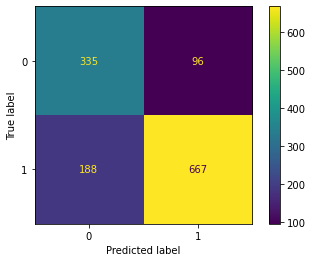

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [41]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.7791601866251944
Precision: 0.8741808650065531
Recall: 0.7801169590643274


In [42]:
sel = SelectFromModel(model)
sel.fit(x_train, y_train)
selected_feat= x_train.columns[(sel.get_support())]
selected_feat

Index(['survey_question_1_2.0', 'survey_question_3_9.0', 'before7_15'], dtype='object')

In [43]:
# Logistic Regression Cross Validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

#cv_results = cross_validate(d_tree, users_train, users['event_label'], scoring = 'f1', cv=10)
#cv_results

cv = KFold(n_splits=10, random_state=0, shuffle=True)

# evaluate model
scores = cross_val_score(model, users_train, users['event_label'], scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.768 (0.019)


### We get a cross-validated accuracy of 0.768, which is decent. Precision and recall values are also good at 0.876 and 0.781, respectively.

# Trying Decision Tree now

I ended up choosing a max_depth of 5 because anything around 10 or above saw a decrease in accuracy. Anything below 5 showed similar performance to 5 but felt too restrictive for future datasets.

In [44]:
d_tree = tree.DecisionTreeClassifier(max_depth = 5)
d_tree = d_tree.fit(x_train, y_train)

In [45]:
tree_y_pred = pd.Series(d_tree.predict(x_test))
tree_y_test = y_test.reset_index(drop=True)
tree_z = pd.concat([tree_y_test, tree_y_pred], axis=1)
tree_z.columns = ['True', 'Prediction']
tree_z.head()

,True,Prediction
0,1,1
1,1,1
2,0,1
3,0,1
4,1,1


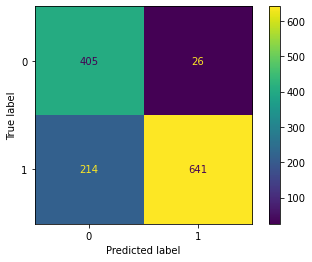

In [46]:
ConfusionMatrixDisplay.from_predictions(tree_y_test, tree_y_pred)

In [47]:
print("Accuracy:", metrics.accuracy_score(tree_y_test, tree_y_pred))
print("Precision:", metrics.precision_score(tree_y_test, tree_y_pred))
print("Recall:", metrics.recall_score(tree_y_test, tree_y_pred))

Accuracy: 0.8133748055987559
Precision: 0.9610194902548725
Recall: 0.7497076023391813


In [48]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

#cv_results = cross_validate(d_tree, users_train, users['event_label'], scoring = 'f1', cv=10)
#cv_results

cv = KFold(n_splits=10, random_state=0, shuffle=True)

# evaluate model
scores = cross_val_score(d_tree, users_train, users['event_label'], scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.810 (0.013)


### Now with a decision tree, we get an accuracy of 0.810 which is better than our logistic regression model. And precision and recall values are still decent at 0.954 and 0.755.

# Trying a Random Forest model now

In [49]:
rf = RandomForestClassifier(n_estimators = 600,
 min_samples_split = 2,
 min_samples_leaf = 8,
 max_features = 'sqrt',
 max_depth = 5,
 bootstrap = True, random_state=0)
rf.fit(x_train, y_train)


RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=8,
                       n_estimators=600, random_state=0)

In [50]:
y_pred = pd.Series(rf.predict(x_test))
y_test = y_test.reset_index(drop=True)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
z.head()

,True,Prediction
0,1,1
1,1,1
2,0,1
3,0,1
4,1,1


In [51]:
# with only question 2 dummy variables
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.78149300155521
Precision: 0.7677238805970149
Recall: 0.9625730994152046


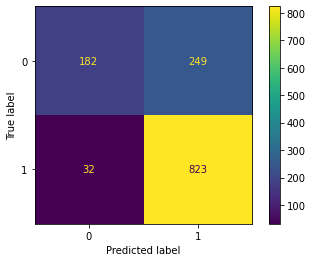

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [53]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(rf, users_train, users['event_label'], scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.775 (0.023)


### Our random forest model does not perform as well as the decision tree for this dataset. This is most likely due to the relatively small number of important predictors. 
### A random forest takes samples of the training data as well as samples of the predictors to train, but this is an issue if there are not a high enough number of predictors to sample from.

In [54]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 600,
 min_samples_split = 2,
 min_samples_leaf = 8,
 max_features = 'sqrt',
 max_depth = 5,
 bootstrap = True))
sel.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=5,
                                                 max_features='sqrt',
                                                 min_samples_leaf=8,
                                                 n_estimators=600))

In [55]:
sel = SelectFromModel(rf)
sel.fit(x_train, y_train)
selected_feat= x_train.columns[(sel.get_support())]
selected_feat

Index(['survey_question_4', 'before7_15'], dtype='object')

# The decision tree is our best performing model between logistic regression, d-tree, and random forests. The final model deems survey_question_4 and before7_15 as the most important predictors

In [56]:
sel = SelectFromModel(d_tree)
sel.fit(x_train, y_train)
selected_feat= x_train.columns[(sel.get_support())]
selected_feat

Index(['survey_question_4', 'before7_15'], dtype='object')

The following chunks are hyperparameter tuning for the randomforest model. The best parameters ended up being 
{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': True}

In [57]:
from sklearn.model_selection import RandomizedSearchCV
import pprint
pp = pprint.PrettyPrinter()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 11, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 11, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4, 8],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

In [ ]:
#base_y_pred = pd.Series(base_model.predict(x_test))
#random_y_pred = pd.Series(rf_random.best_estimator_.predict(x_test))

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, base_y_pred))
print("Precision:", metrics.precision_score(y_test, base_y_pred))
print("Recall:", metrics.recall_score(y_test, base_y_pred))

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, random_y_pred))
print("Precision:", metrics.precision_score(y_test, random_y_pred))
print("Recall:", metrics.recall_score(y_test, random_y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
'''
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 5, 6],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [1, 2, 5],
    'n_estimators': [100, 400, 700, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
'''

In [ ]:
'''
grid_search.fit(x_train, y_train)
grid_search.best_params_
'''


In [ ]:
'''
best_grid = grid_search.best_estimator_
best_y_pred = pd.Series(grid_search.best_estimator_.predict(x_test))
print("Accuracy:", metrics.accuracy_score(y_test, best_y_pred))
'''